# Use the MovieLens 10 M dataset 
The dataset is available from grouplens.org/datasets/movielens: https://grouplens.org/datasets/movielens/

# Step 1: Connect to Snowflake 


In [19]:
import os 
from pathlib import Path 
from dotenv import load_dotenv
import snowflake.snowpark.functions as F 
import snowflake.snowpark.types as T 

from utils import build_snowflake_session


# Build the .env full path 
env_path = Path(os.getcwd()).parent / ".env"
# Load the .env file 
load_dotenv(env_path) 

# Get connection credentials 
config_params  = {
    "account": os.getenv("SNOWFLAKE_ACCOUNT"),
    "user": os.getenv("SNOWFLAKE_USER"),
    "password": os.getenv("SNOWFLAKE_PASSWORD"),
    "role": "ML_MODEL_ROLE",
    "warehouse": "ML_MODEL_WH",
    "database": "ML_MODEL_DATABASE",
    "schema": "MOVIE_RECSYS",
    }

session = build_snowflake_session(config_params)

# Step 2: Load MovieLens 10M dataset and write them to Snowflake Table  

In [ ]:
import pandas as pd 
from snowflake.connector.pandas_tools import write_pandas

movies = pd.read_csv("data/ml-10M100K/movies.dat", delimiter="::", header=None, names=["movieId", "title", "genres"])
ratings = pd.read_csv("data/ml-10M100K/ratings.dat", delimiter="::", header=None, names=["userId", "movieId", "rating", "timestamp"])
tags= pd.read_csv("data/ml-10M100K/tags.dat", delimiter="::", header=None, names=["userId", "movieId", "tag", "timestamp"])


print(movies.head(5))
print(ratings.head(5))
print(tags.head(5))



/var/folders/z0/hsrwl1n15cl2pyfrkvy3brrm0000gn/T/ipykernel_74569/4201758637.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv("data/ml-10M100K/movies.dat", delimiter="::", header=None, names=["movieId", "title", "genres"])
/var/folders/z0/hsrwl1n15cl2pyfrkvy3brrm0000gn/T/ipykernel_74569/4201758637.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv("data/ml-10M100K/ratings.dat", delimiter="::", header=None, names=["userId", "movieId", "rating", "timestamp"])


In [5]:

session.sql("USE CURRENT_DATABASE()")
session.sql("USE CURRENT_SCHEMA()")

ratings_df = session.create_dataframe(ratings)
# Rename columns to remove double quotes 
ratings_df = (ratings_df
              .select(*[F.col(col_name).alias(col_name.strip('"')) for col_name in ratings_df.columns]))
#.write.mode("overwrite").save_as_table("tmdb_5000_credits")
movies_df = session.create_dataframe(movies)
movies_df = (movies_df
              .select(*[F.col(col_name).alias(col_name.strip('"')) for col_name in movies_df.columns]))

tags_df = session.create_dataframe(tags)
tags_df = (tags_df
              .select(*[F.col(col_name).alias(col_name.strip('"')) for col_name in tags_df.columns]))
#.write.mode("overwrite").save_as_table("tmdb_5000_movies")

print(ratings_df.schema)
print(movies_df.schema)
print(tags_df.schema)

StructType([StructField('USERID', LongType(), nullable=True), StructField('MOVIEID', LongType(), nullable=True), StructField('RATING', DoubleType(), nullable=True), StructField('TIMESTAMP', LongType(), nullable=True)])
StructType([StructField('MOVIEID', LongType(), nullable=True), StructField('TITLE', StringType(), nullable=True), StructField('GENRES', StringType(), nullable=True)])
StructType([StructField('USERID', LongType(), nullable=True), StructField('MOVIEID', LongType(), nullable=True), StructField('TAG', StringType(), nullable=True), StructField('TIMESTAMP', LongType(), nullable=True)])


In [6]:
# Write to Snowflake tables
ratings_df.write.mode("overwrite").save_as_table("ml_10m_ratings")
movies_df.write.mode("overwrite").save_as_table("ml_10m_movies")
tags_df.write.mode("overwrite").save_as_table("ml_10m_tags")

In [7]:
# The size of the dataframes 
ratings_df.count(), movies_df.count(), tags_df.count()

(10000054, 10681, 95580)

In [8]:
# Load the snowflake table 

load_ratings_df = session.table("ml_10m_ratings")
load_movies_df = session.table("ml_10m_movies")
load_tags_df = session.table("ml_10m_tags")

ratings_df.count(), movies_df.count(), tags_df.count()

(10000054, 10681, 95580)

In [9]:
load_movies_df.show(5)
load_ratings_df.show(5)
load_tags_df.show(5)

------------------------------------------------------------------------------------------------
|"MOVIEID"  |"TITLE"                             |"GENRES"                                     |
------------------------------------------------------------------------------------------------
|1          |Toy Story (1995)                    |Adventure|Animation|Children|Comedy|Fantasy  |
|2          |Jumanji (1995)                      |Adventure|Children|Fantasy                   |
|3          |Grumpier Old Men (1995)             |Comedy|Romance                               |
|4          |Waiting to Exhale (1995)            |Comedy|Drama|Romance                         |
|5          |Father of the Bride Part II (1995)  |Comedy                                       |
------------------------------------------------------------------------------------------------

-------------------------------------------------
|"USERID"  |"MOVIEID"  |"RATING"  |"TIMESTAMP"  |
--------------------------

# Aggregate user ratings to compute the Movie Popularity 

We dont consider the time of rating, and only aggregate all ratings per movieId. 

In [10]:
agg_rating_per_movieid = (load_ratings_df
                          .group_by("MOVIEID")
                          .agg(F.count("USERID").alias("rating_count"), 
                               F.avg("RATING").alias("rating_average")))

agg_rating_per_movieid.show()

---------------------------------------------------
|"MOVIEID"  |"RATING_COUNT"  |"RATING_AVERAGE"    |
---------------------------------------------------
|249        |3137            |3.6824992030602486  |
|257        |2455            |3.430142566191446   |
|454        |15622           |3.4946869799001408  |
|671        |3620            |3.6907458563535913  |
|780        |26042           |3.3759311880807927  |
|931        |1296            |3.9112654320987654  |
|1101       |11331           |3.412540817227076   |
|838        |4476            |3.8325513851653263  |
|910        |5816            |4.108923658872077   |
|930        |2705            |4.219038817005545   |
---------------------------------------------------



# Movie Popularity Based Filtering 

Use the IMDB weighted average formula: https://medium.com/the-owl/recommender-systems-f62ad843f70c
![Screenshot 2024-11-20 at 12.06.56.png](<attachment:Screenshot 2024-11-20 at 12.06.56.png>)


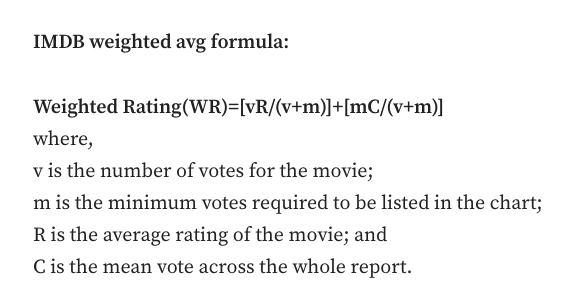

In [11]:
# Compute C and m 
C = agg_rating_per_movieid.select(F.avg("rating_average").alias("mean_value")).collect()[0][0]
m = agg_rating_per_movieid.select(F.approx_percentile("rating_count", 0.5).alias("quantile_90")).collect()[0][0]
print(C)
print("rating_count", m)
valid_movies_df = agg_rating_per_movieid.where(F.col("rating_count") >= m)
valid_movies_df.count(), movies_df.count()

3.1919554229212106
rating_count 135.22564102564104


(5332, 10681)

In [13]:
import snowflake.snowpark.types as T 


def weighted_rating(vote_count: int, vote_average: float) -> float: 
    v = vote_count
    R = vote_average
    return (v/(v+m) * R) + (m/(m+v) * C)

# Important: Register the UDF explicitly with the session 
weighted_rating_udf = session.udf.register(weighted_rating, 
                                           return_type=T.FloatType(), 
                                           input_types=[T.DoubleType(), T.FloatType()])
# Apply the UDF to the DataFrame
valid_movies_df = (valid_movies_df
                   .with_column("score", weighted_rating_udf(F.col("rating_count"), F.col("rating_average"))))


# Sort movies based on score calculated above 
valid_movies_df = valid_movies_df.order_by(F.col("score").desc())
# show top 15 movies 
valid_movies_df.show(15)


----------------------------------------------------------------------
|"MOVIEID"  |"RATING_COUNT"  |"RATING_AVERAGE"   |"SCORE"            |
----------------------------------------------------------------------
|318        |31126           |4.457238321660348  |4.451765129629251  |
|858        |19814           |4.415085293227011  |4.40679431874279   |
|50         |24037           |4.367142322253193  |4.360568024786874  |
|527        |25777           |4.363482949916592  |4.357369211829721  |
|912        |12507           |4.319740945070761  |4.307677759006654  |
|904        |8825            |4.316543909348442  |4.299571881515695  |
|1221       |13281           |4.303215119343423  |4.292014442728747  |
|2019       |5751            |4.314119283602851  |4.288339550264249  |
|750        |11774           |4.298072023101749  |4.285512404968959  |
|1193       |14435           |4.292379632836855  |4.282166642808274  |
|922        |3255            |4.321966205837174  |4.276893562106159  |
|1212 

In [14]:
# Join with movie_df to get the movie title 
valid_movies_w_title_df = (valid_movies_df
                           .join(load_movies_df, "movieId"))

print(valid_movies_df.count(), valid_movies_w_title_df.count())

# show top 15 movies 
valid_movies_w_title_df.order_by(F.col("score").desc()).select("title", "rating_count", "rating_average", "score").show(15)


5332 5332
---------------------------------------------------------------------------------------------------------------
|"TITLE"                                             |"RATING_COUNT"  |"RATING_AVERAGE"   |"SCORE"            |
---------------------------------------------------------------------------------------------------------------
|Shawshank Redemption, The (1994)                    |31126           |4.457238321660348  |4.451765129629251  |
|Godfather, The (1972)                               |19814           |4.415085293227011  |4.40679431874279   |
|Usual Suspects, The (1995)                          |24037           |4.367142322253193  |4.360568024786874  |
|Schindler's List (1993)                             |25777           |4.363482949916592  |4.357369211829721  |
|Casablanca (1942)                                   |12507           |4.319740945070761  |4.307677759006654  |
|Rear Window (1954)                                  |8825            |4.316543909348442  |4.2

In [15]:
# Scale the weighted score 

max_popularity = valid_movies_w_title_df.select(F.max("score")).collect()[0][0]
min_popularity = valid_movies_w_title_df.select(F.min("score")).collect()[0][0]

print(max_popularity)

valid_movies_popularity_df = (valid_movies_w_title_df
                              .with_column("popularity", 
                                           ( (F.col("score") - F.lit(min_popularity)) / (F.lit(max_popularity)-F.lit(min_popularity)) )*100))

                                                                
valid_movies_popularity_df.order_by(F.col("popularity").desc()).show()

4.451765129629251
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"MOVIEID"  |"RATING_COUNT"  |"RATING_AVERAGE"   |"SCORE"            |"TITLE"                                             |"GENRES"                |"POPULARITY"        |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|318        |31126           |4.457238321660348  |4.451765129629251  |Shawshank Redemption, The (1994)                    |Drama                   |100.00000000000003  |
|858        |19814           |4.415085293227011  |4.40679431874279   |Godfather, The (1972)                               |Crime|Drama             |98.37952674362208   |
|50         |24037           |4.367142322253193  |4.360568024786874  |Usual Suspects, The (1995)                          |Crime|Mys

# Visualization of Popularity Based Recommender System 

                                               TITLE  POPULARITY
0                   Shawshank Redemption, The (1994)  100.000000
1                              Godfather, The (1972)   98.379527
2                         Usual Suspects, The (1995)   96.713814
3                            Schindler's List (1993)   96.598548
4                                  Casablanca (1942)   94.807972
5                                 Rear Window (1954)   94.515885
6                     Godfather: Part II, The (1974)   94.243561
7        Seven Samurai (Shichinin no samurai) (1954)   94.111141
8  Dr. Strangelove or: How I Learned to Stop Worr...   94.009268
9             One Flew Over the Cuckoo's Nest (1975)   93.888707


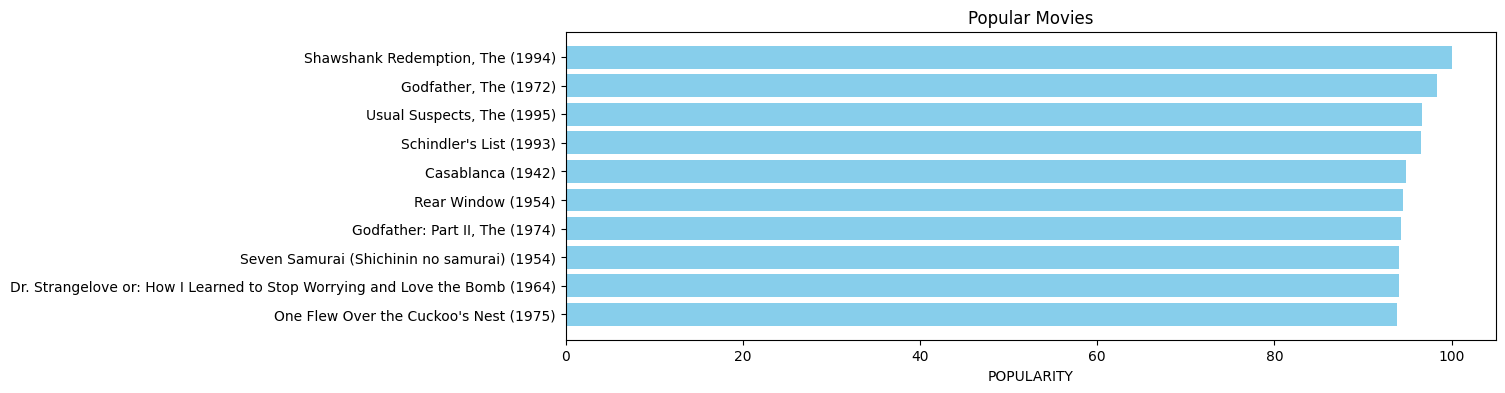

In [16]:
import matplotlib.pyplot as plt 

popularity_df = valid_movies_popularity_df.order_by(F.col("POPULARITY").desc())

# Select the top 6 rows from the DataFrame, skipping offset rows from the begining 
selected_pd = popularity_df.select("TITLE", "POPULARITY").limit(10).to_pandas()

print(selected_pd)

plt.figure(figsize=(12, 4))

plt.barh(selected_pd["TITLE"], selected_pd["POPULARITY"], align="center", color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("POPULARITY")
plt.title("Popular Movies")

plt.show()


# Bayesian Average: 
![Screenshot 2024-11-20 at 13.16.11.png](<attachment:Screenshot 2024-11-20 at 13.16.11.png>)
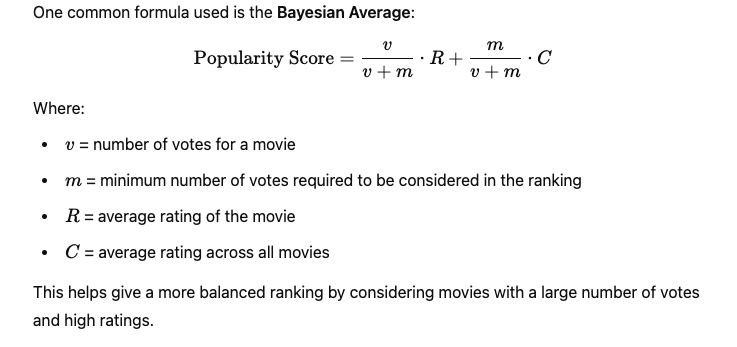

In [17]:
# Write the movie popularity table to Snowflake 
valid_movies_popularity_df.write.mode("overwrite").save_as_table("valid_movie_popularity_10M")

# Collaborative Filtering Approach 

## Single Value Decomposition 

Using Surprise library: https://surprise.readthedocs.io/en/stable/getting_started.html#use-cross-validation-iterators

In [1]:
from surprise import Reader, Dataset, SVD 
import pandas as pd 


reader = Reader()
ratings = pd.read_csv("data/ml-10M100K/ratings.dat", delimiter="::", header=None, names=["userId", "movieId", "rating", "timestamp"])
ratings.head()

/var/folders/z0/hsrwl1n15cl2pyfrkvy3brrm0000gn/T/ipykernel_59047/4020659925.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv("data/ml-10M100K/ratings.dat", delimiter="::", header=None, names=["userId", "movieId", "rating", "timestamp"])


,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [2]:
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

In [21]:
from surprise.model_selection import KFold 
from surprise import accuracy

# Using SVD 
svd = SVD()

# Running 10-fold cross-validation and then print results 
#cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=4, verbose=True)
# Define a cross-validation iterator 
kf = KFold(n_splits=3)

for trainset, testset in kf.split(data):
    # Train and test the model 
    svd.fit(trainset)
    predictions = svd.test(testset)

    # Compute and print Root Mean Squared Error 
    print(accuracy.rmse(predictions, verbose=True))
    

RMSE: 0.8087
0.8087327957223751
RMSE: 0.8080
0.8080330309589134
RMSE: 0.8084
0.8084039342279167


# Tune algorithm parameters with GridSearchCV

In [ ]:
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold 
from surprise import accuracy

# Using SVD 
svd = SVD()

param_grid = {"n_epochs": [1, 2], 
              "lr_all": [0.002, 0.005], 
              "reg_all": [0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

# Best RMSE score 
print(gs.best_score["rmse"])

# Combination of parameters that gives the best RMSE score 
print(gs.best_params["rmse"])

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1061cd340>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sf-ml-env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
# We can now use the model that yields the best rmse: 
best_svd = gs.best_estimator["rmse"]
trainset = data.build_full_trainset()
best_svd.fit(trainset)

# Use MLFlow 


# Surprise

* suprise.model_selection.cross_validate
Run a cross validation procedure for a given algorithm, reporting accuracy measures and computation times. 
-cv (cross-validation iterator) - Determines how the data parameter will be split (i.e., how trainsets and testsets will be defined.) If an int is passed, KFold is used with the appropriate n_splits parameter. If None, KFold is used with n_splits = 5. 

* surprise.model_selection.split.KFold
A basic cross-validation iterator. 
Each fold is used once as a testset while the k-1 remaining folds are used for training. 


In [5]:
import mlflow 
from mlflow.models import infer_signature   # Generate a model signature, which describes the schema of inputs and outputs of the model.
import mlflow.sklearn     # Even though Surprise is not scikit-learn, we will use this 
import pandas as pd 
from surprise import Dataset, SVD, Reader 
from surprise.model_selection import cross_validate



def get_or_create_experiment(experiment_name: str) -> str: 
    # check if the experiment already exists 
    experiment = mlflow.get_experiment_by_name(experiment_name)

    if experiment is None: 
        # Experiment does not exist 
        experiment_id = mlflow.create_experiment(experiment_name)
        print(f"Experiment '{experiment_name}' created with ID: {experiment_id}")
    else: 
        # Experiment already exists 
        experiment_id = experiment.experiment_id
        print(f"Experiment '{experiment_name}' already exists with ID: {experiment_id}")

    # Set the experiment for subsequent runs 
    mlflow.set_experiment(experiment_name)
    return experiment_id

def train_svd_model():
    # Load training dataset 
    reader = Reader()
    ratings = pd.read_csv("data/ml-10M100K/ratings.dat", delimiter="::", header=None, names=["userId", "movieId", "rating", "timestamp"])
    data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)
    trainset = data.build_full_trainset()

    # Specify model and parameters 
    model = SVD(n_factors=50, lr_all=0.005, reg_all=0.02)
    svd_params = {
                  "model_name": "SVD",
                  "n_factors": 50, 
                  "lr_all": 0.005, 
                  "reg_all": 0.02, 
                  "dataset": "movielen-10m"}
    
    remote_server_uri = "http://127.0.0.1:8080"
    mlflow.set_tracking_uri(remote_server_uri)
    
    experiment_name = "/movie_recommender"
    experiment_id = get_or_create_experiment(experiment_name)

    # Start with an MLflow run 
    with mlflow.start_run(experiment_id=experiment_id): 
        mlflow.log_params(svd_params)

        # Train the model
        CV = 5
        cross_val_results = cross_validate(model, data, measures=["rmse", "mae"], cv=CV, verbose=True)
        # Calculate average metrics 
        avg_rmse = cross_val_results["test_rmse"].mean()
        avg_mae = cross_val_results["test_mae"].mean()
        
        # Log cross_validation params 
        mlflow.log_param("KFold", CV)
        
        # Log metrics 
        mlflow.log_metrics({"avg_rmse": avg_rmse, 
                            "avg_mae": avg_mae})
        
        """
        # Save and log the model 
        model_file_path = "surprise_svd_movielen_model.pkl"
        with open(model_file_path, "wb") as f: 
            import pickle 
            pickle.dump(model, f)

        mlflow.sklearn.log_model(model, artifact_path=model_file_path)
       
        # Predict for each user-item pair in the training set 
        predictions = []
        count = 0 
        print("start to inference the trained SVD model....")
        for uid, iid, true_rating in trainset.all_ratings():
            prediction = model.predict(uid, iid, true_rating)
            predictions.append(prediction)
            count += 1 
            if count == 10:
                break 

        signature = infer_signature(trainset, predictions)
        """
        # Log the model with MLFlow, including the signature 
        mlflow.sklearn.log_model(model, artifact_path="surprise_svd_movielen_model")

        print(f"Run logged with RMSE: {avg_rmse}, MAE: {avg_mae}")
        

    

In [6]:
train_svd_model()

/var/folders/z0/hsrwl1n15cl2pyfrkvy3brrm0000gn/T/ipykernel_32486/1416605533.py:30: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv("data/ml-10M100K/ratings.dat", delimiter="::", header=None, names=["userId", "movieId", "rating", "timestamp"])


Experiment '/movie_recommender' already exists with ID: 449503038175960848
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7977  0.7972  0.7972  0.7978  0.7982  0.7976  0.0004  
MAE (testset)     0.6119  0.6116  0.6116  0.6121  0.6120  0.6119  0.0002  
Fit time          31.72   37.74   37.83   51.54   43.52   40.47   6.68    
Test time         4.06    82.51   37.12   73.70   48.25   49.13   27.91   


2024/11/21 13:50:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged with RMSE: 0.7976169080664947, MAE: 0.6118508681182483
🏃 View run popular-zebra-274 at: http://127.0.0.1:8080/#/experiments/449503038175960848/runs/5ee564a7dfba424d8de5f4c5152794cc
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/449503038175960848


# Inference the trained model 

In [ ]:
import mlflow 
from surprise import Dataset, SVD, Reader 
import pandas as pd 


def predict(model_url: str, data_path: str): 
    # prepare test data
    #reader = Reader()
    ratings_pd = pd.read_csv(data_path, delimiter="::", header=None, names=["userId", "movieId", "rating", "timestamp"])
    #data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

    # Load model as a PyFuncModel 
    loaded_model = mlflow.pyfunc.load_model(model_url)

    # Predict on a Pandas DataFrame.
    predictions = loaded_model.predict(ratings_pd)
    print("predictions are: \n")
    print(predictions)

model_url = 'runs:/175cf06654134effbc8ca7cd515556cf/surprise_svd_movielen_model.pkl'
data_path = "data/ml-10M100K/ratings.dat"